In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

from dask.distributed import Client
client = Client(n_workers=5, threads_per_worker=1,
                memory_limit="24G",
                dashboard_address="localhost:8787")


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [2]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [96]:
%%time

#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 16s, sys: 18.7 s, total: 1min 34s
Wall time: 1min 24s


In [97]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 3.21 s, sys: 683 ms, total: 3.89 s
Wall time: 3.36 s


In [98]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 2min 16s, sys: 32.4 s, total: 2min 49s
Wall time: 2min 38s


## TAPE

In [99]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(client=client)
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 5,Total memory: 111.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34001,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 5
Started: 57 minutes ago,Total memory: 111.76 GiB
Comm: tcp://127.0.0.1:42829,Total threads: 1
Dashboard: http://127.0.0.1:35722/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:43689,


In [100]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [219]:
%%time
# know dipper
lc = ens.source.loc[4078931319013244928]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 16 s, sys: 1.04 s, total: 17.1 s
Wall time: 17.5 s


In [212]:
lc.head(1)

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4047009306271285248,289.188654,25.025112,0.44366,9.107895,1.524125,1636148068921376768,2023504645322072192,-0.735488,0.032067,-9.362067,...,0,638,17.428768,0.022976,58206.49198,19,g,9,920000,920183


In [220]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

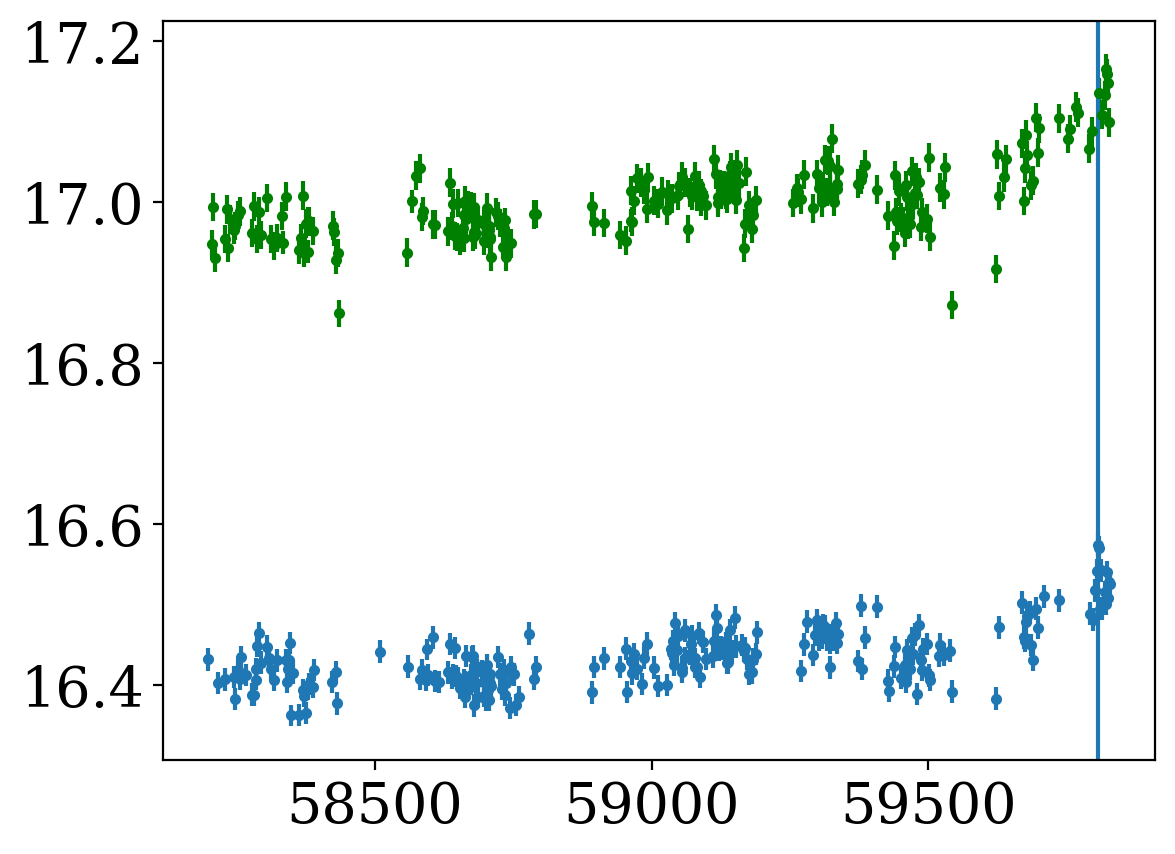

In [224]:
plt.errorbar(time, mag, magerr, fmt='.')
plt.errorbar(timeg, magg, magerrg, fmt='.', color='green')
plt.axvline(59807.31191)

In [223]:
# test should be nan because it's *not* a real dipper.
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

2.6245868 0.10486161 2.7563145
      peak_loc  window_start   window_end  N_1sig_in_dip  N_in_dip  \
0  59807.31191   59801.20875  59813.19658            4.0       4.0   

   loc_forward_dur  loc_backward_dur  dip_power  average_dt_dif  
0          6.10316           5.88467   3.844841             0.0  
Nphot                         2.400000e+02
biweight_scale                3.461178e-02
frac_above_2_sigma            4.166667e-02
Ndips                         1.000000e+00
rate                          6.132517e-04
chi2dof                       1.014158e+00
ADF_const                    -4.624648e-01
ADF_const_trend              -2.798006e+00
ADF_pval_const                8.991355e-01
ADF_pval_const_trend          1.976778e-01
skew                          9.245210e-01
kurtosis                      1.285840e+00
mad                           2.228355e-02
stetson_i                     1.064999e+03
stetson_j                     2.662099e+02
stetson_k                     7.631465e-01
invNeuma